In [1]:
import sys
#sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import dareblopy as db
from IPython.display import Image, display
import PIL.Image

import os
import shutil
import time

from data.ImagenetDataset import get_zipped_dataloaders
from data.utils import *

print(type(getClassToIndexMapping))
print(type(generateNewImageDataset))

S_BASE_PATH = "data/imagenet_images"
T_BASE_PATH = "data/imagenet_full"

from_path = os.path.join(os.getcwd(), S_BASE_PATH)
to_path = os.path.join(os.getcwd(), T_BASE_PATH)
print(from_path)
print(to_path)
IS_DEBUG = False


<class 'function'>
<class 'function'>
/home/alex/Documents/pythonProjects/anytimeDnn/data/imagenet_images
/home/alex/Documents/pythonProjects/anytimeDnn/data/imagenet_full


In [3]:
# create a new dataset
set_type = "train"
print(f"Create a new {set_type}-set at\n{to_path}\nbased on files at\n{from_path}")

#generateNewImageDataset(from_path, to_path, set_type, ratio=1.0, force_process=False)

set_type = "val"
generateNewImageDataset(from_path, to_path, set_type, ratio=1.0)


x/Documents/pythonProjects/anytimeDnn/data/imagenet_images/val/prairie gentian/476414258_068612be17.jpg 
 ->/home/alex/Documents/pythonProjects/anytimeDnn/data/imagenet_full/val/3856.jpg
Copy: 
 --/home/alex/Documents/pythonProjects/anytimeDnn/data/imagenet_images/val/prairie gentian/458711771_f2f272a776.jpg 
 ->/home/alex/Documents/pythonProjects/anytimeDnn/data/imagenet_full/val/3857.jpg
Copy: 
 --/home/alex/Documents/pythonProjects/anytimeDnn/data/imagenet_images/val/prairie gentian/2467806616_55639b1542.jpg 
 ->/home/alex/Documents/pythonProjects/anytimeDnn/data/imagenet_full/val/3858.jpg
Copy: 
 --/home/alex/Documents/pythonProjects/anytimeDnn/data/imagenet_images/val/prairie gentian/503596398_00bc701122.jpg 
 ->/home/alex/Documents/pythonProjects/anytimeDnn/data/imagenet_full/val/3859.jpg
Copy: 
 --/home/alex/Documents/pythonProjects/anytimeDnn/data/imagenet_images/val/prairie gentian/5506224_40e0a6fb4f.jpg 
 ->/home/alex/Documents/pythonProjects/anytimeDnn/data/imagenet_full/val

In [4]:
train_loader, val_loader, test_loader = get_zipped_dataloaders(to_path, batch_size=1, use_valid=True)

/home/alex/Documents/pythonProjects/anytimeDnn/data/imagenet_full/index-train.txt
/home/alex/Documents/pythonProjects/anytimeDnn/data/imagenet_full/index-val.txt


In [7]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

31891
3543
3953


(256, 341, 3)


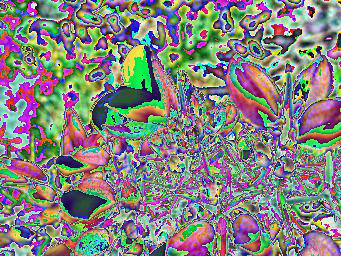

In [8]:
arch = db.open_zip_archive(os.path.join(to_path, "index-train.zip"))
img = arch.read_jpg_as_numpy("0.jpg")
print(img.shape)
display(PIL.Image.fromarray(img))

In [4]:

train_loader, loader, _ = get_zipped_dataloaders(to_path, 8, num_worker=1, use_valid=False)

print("Train data")
benchmarkDataloader(train_loader, it_limit=100)
print("Val data")
benchmarkDataloader(loader, it_limit=100)

train_loader, loader, _ = get_zipped_dataloaders(to_path, 8, num_worker=1, use_valid=True)

print("Train data")
benchmarkDataloader(train_loader, it_limit=100)
print("Val data")
benchmarkDataloader(loader, it_limit=100)


/home/alex/Documents/pythonProjects/anytimeDnn/data/imagenet_red/index-train.txt
/home/alex/Documents/pythonProjects/anytimeDnn/data/imagenet_red/index-val.txt
Train data
99
Avg batch load time    32.82 ms - Max:    75.48ms - Min:    22.82ms
Avg image load time     4.10 ms - Max:     9.43ms - Min:     2.85ms
Val data
Avg batch load time    21.81 ms - Max:    44.75ms - Min:     2.70ms
Avg image load time     2.73 ms - Max:     5.59ms - Min:     0.34ms
/home/alex/Documents/pythonProjects/anytimeDnn/data/imagenet_red/index-train.txt
/home/alex/Documents/pythonProjects/anytimeDnn/data/imagenet_red/index-val.txt
Train data
99
Avg batch load time    36.05 ms - Max:    55.77ms - Min:    29.18ms
Avg image load time     4.51 ms - Max:     6.97ms - Min:     3.65ms
Val data
Avg batch load time    35.96 ms - Max:    57.74ms - Min:     6.64ms
Avg image load time     4.50 ms - Max:     7.22ms - Min:     0.83ms


(0.004495007651192802, 0.007217586040496826, 0.0008304417133331299)

In [14]:
from msdnet.dataloader import get_dataloaders_alt
DATA_PATH = "data/imagenet_images"
ARCH = 'resnet'
train_loader, test_loader, _ = get_dataloaders_alt(
    DATA_PATH, 
    data="ImageNet", 
    use_valid=True, 
    save='data/{}-{}'.format(ARCH, time.time()),
    batch_size=8, 
    workers=1, 
    splits=['train', 'val', 'test'])
print("Old loader")
benchmarkDataloader(test_loader, it_limit=100)